In [1]:
import deap
from functools import partial
from deap import base, creator, tools, algorithms
import random
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

from xailib.data_loaders.dataframe_loader import prepare_dataframe
from xailib.explainers.lime_explainer import LimeXAITabularExplainer
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.explainers.shap_explainer_tab import ShapXAITabularExplainer
from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

In [3]:
df=pd.read_csv('C:/Users/Gabriel/Pasta/Machine Learning/BINÁRIO_HRV.csv')
df_sem_coluna = df.drop(columns=["IAH","F","M"])
df_sem_coluna.to_csv('BINÁRIO_FINAL.csv', index=False)

In [4]:
source_file = 'C:/Users/Gabriel/Pasta/Machine Learning/Aplicações Biblioteca LORE/BINÁRIO_FINAL.csv'
class_field = 'CLASSE'
dfLORE = pd.read_csv(source_file, skipinitialspace=True, na_values='?', keep_default_na=True)

In [5]:
dfLORE, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = prepare_dataframe(dfLORE, class_field)
dfLORE

,T90,SATMIN,IDADE,ALTURA,PESO,IMC,PIP,W0,W1,W2,...,PHASEEN,AC,DC,PORTAS,GUZIKS,EHLERS,BIN0V,BIN1V,BIN2V,CLASSE
0,0.03,87,35,1.660000,69.600000,25.257657,49.5922,4.0768,48.3943,42.1703,...,0.9303,-11.9732,10.4526,46.6220,47.8699,-0.2132,17.2253,68.7786,13.9962,1
1,0.00,92,50,1.590000,98.700000,39.041177,48.4985,6.3788,52.1003,31.1333,...,0.9348,-6.3287,6.1144,49.2434,48.9933,-0.1273,24.8110,60.5646,14.6244,1
2,0.00,92,27,1.800000,91.000000,28.086420,51.0391,14.4829,30.6881,42.0710,...,0.9239,-13.4549,14.9428,52.3657,57.2754,2.4017,27.1533,51.4026,21.4442,1
3,1.37,41,61,1.590000,103.700000,41.018947,60.8169,5.6235,20.4419,59.7282,...,0.9101,-14.5812,14.4796,50.0457,50.2848,0.0960,11.2946,58.4855,30.2198,1
4,0.07,88,26,1.649234,59.700000,21.948760,47.7805,1.4780,55.0176,42.2484,...,0.8909,-29.3785,35.4046,54.5368,56.3937,1.4414,12.7135,79.9516,7.3349,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,34.30,69,63,1.620000,89.500000,34.103033,54.1595,13.1081,30.2523,37.5912,...,0.9178,-11.6846,10.8219,47.8445,48.0653,-0.2136,31.9158,46.3412,21.7430,0
287,68.40,67,64,1.640000,127.000000,47.218917,64.2736,1.0004,23.7305,56.6400,...,0.8764,-5.2141,7.1196,57.4381,57.5743,1.4235,9.6522,61.7281,28.6197,0
288,1.80,82,51,1.650000,94.200000,34.600551,48.8423,9.6049,43.5728,37.5027,...,0.9269,-19.3183,21.7097,52.3061,56.6817,2.0795,24.6303,59.7656,15.6041,0
289,4.60,83,59,1.649234,89.262007,32.817260,62.6354,5.1821,26.5503,43.4533,...,0.8945,-3.5383,4.1281,52.1756,53.5385,0.7252,21.7171,52.3949,25.8880,0


In [7]:
dfLORE['CLASSE'].value_counts()

CLASSE
0    181
1    110
Name: count, dtype: int64

In [6]:
#separando conjunto de teste e de treino
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dfLORE, test_size=0.3, random_state=42)

In [7]:
train_set.iloc[:, 0:40]

,T90,SATMIN,IDADE,ALTURA,PESO,IMC,PIP,W0,W1,W2,...,ATTEN,PHASEEN,AC,DC,PORTAS,GUZIKS,EHLERS,BIN0V,BIN1V,BIN2V
258,23.60,75,67,1.61,76.0,29.319856,75.0727,4.2549,11.3053,39.4062,...,2.3475,0.6924,-1.2289,1.3699,51.0043,51.3277,0.2126,23.9461,42.7151,33.3388
86,14.40,81,51,1.52,48.0,20.775623,69.9003,1.7170,10.4227,64.2845,...,1.4629,0.8812,-7.1137,6.5278,47.4961,46.7781,-0.5562,5.5659,56.1571,38.2771
229,10.80,77,70,1.64,69.0,25.654372,50.9938,12.7780,34.7683,39.3050,...,2.6883,0.9105,-9.6844,9.9350,51.1953,50.8643,0.1930,31.9211,52.4566,15.6223
92,0.20,87,36,1.69,74.0,25.909457,54.0109,3.0068,41.3305,46.3030,...,1.9035,0.9189,-11.9485,10.7005,48.5700,51.0898,0.2328,16.2400,69.8136,13.9465
97,1.40,83,27,1.55,70.0,29.136316,50.3281,5.6408,50.0402,32.0461,...,2.3812,0.9162,-6.2342,8.9840,51.3459,52.4776,0.4417,29.3564,58.4494,12.1942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,18.39,49,32,1.60,123.7,48.320312,52.5720,8.5143,39.1033,38.5719,...,2.4293,0.9233,-9.0357,8.4255,48.2910,49.9403,-0.0504,25.6497,54.3417,20.0087
71,18.70,73,56,1.56,85.0,34.927679,61.2185,3.0387,20.9251,65.3840,...,1.6233,0.9141,-11.6971,11.4989,49.8138,51.2127,0.4347,9.1912,67.6111,23.1977
106,0.70,79,47,1.48,70.0,31.957633,58.2807,2.5312,33.7759,50.0790,...,1.9538,0.9216,-7.9992,7.7740,52.0880,53.6257,0.7734,13.8376,66.4834,19.6790
270,99.70,53,40,1.85,188.0,54.930606,61.2457,4.1517,27.5211,48.8306,...,2.0666,0.9033,-5.0520,5.8209,52.2840,52.9548,0.4492,16.9553,61.9908,21.0539


In [8]:
from sklearn.experimental import enable_iterative_imputer
from imblearn.over_sampling import SMOTE
#Realiza o over-sampling
smote = SMOTE(random_state=7)
from sklearn.impute import IterativeImputer as imputer
X_T, y_T = smote.fit_resample(train_set.iloc[:, 0:40], train_set['CLASSE'],)
from collections import Counter
print(y_T.value_counts())

CLASSE
0    129
1    129
Name: count, dtype: int64


In [9]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(random_state=7)
RF.fit(X_T,y_T)

RandomForestClassifier(random_state=7)

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
y_t = test_set['CLASSE'].copy()
X_t = test_set.iloc[:, 0:40].copy()
print(y_t.value_counts())
predict=RF.predict(X_t)
accuracy_score(predict,y_t)

CLASSE
0    52
1    36
Name: count, dtype: int64


0.7272727272727273

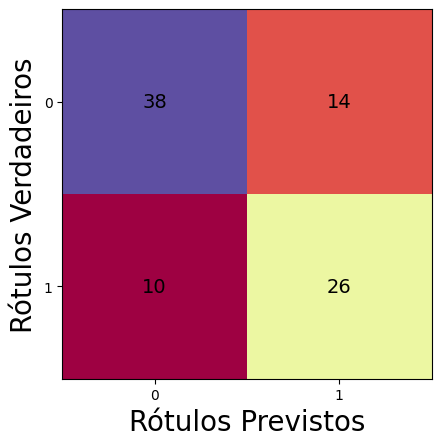

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

unique_labels = np.unique(y_t)
conf_matrix = confusion_matrix(y_t, predict, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap="Spectral", colorbar=False, values_format='d')
for text in disp.im_.axes.texts:
    text.set_color('black')
    text.set_fontsize(14)
plt.xlabel('Rótulos Previstos', fontsize=20)
plt.ylabel('Rótulos Verdadeiros', fontsize=20)
plt.show()

In [12]:
bbox = sklearn_classifier_wrapper(RF)

In [13]:
source_file = 'C:/Users/Gabriel/Pasta/Machine Learning/Aplicações Biblioteca LORE/HRVover.csv'
class_field = 'CLASSE'

In [14]:
instância = X_t.iloc[3].values
instância.reshape(1, -1)
print('Instance ',instância)
print('True class ', y_t.iloc[3])
print('Predicted class ', predict[3])

Instance  [ 9.20000000e+00  7.00000000e+01  6.50000000e+01  1.65000000e+00
  1.22000000e+02  4.48117539e+01  5.99173000e+01  1.75890000e+00
  2.82187000e+01  5.85742000e+01  1.14482000e+01  1.89472000e+01
  4.84871000e+01  8.31590000e+00  2.42498000e+01  3.83835500e+02
  1.53870600e+02  2.42811500e+02  3.87623000e+01  6.12377000e+01
  6.87300000e-01  8.50868300e+02  3.76630000e+01  2.73505000e+01
  1.07080000e+00  1.94190000e+00  1.76710000e+00  5.95200000e-01
  2.52090000e+00  4.69820000e+00  1.64490000e+00  9.06200000e-01
 -9.57790000e+00  6.89270000e+00  4.80135000e+01  4.84821000e+01
 -1.61400000e-01  9.41930000e+00  6.85894000e+01  2.19913000e+01]
True class  0
Predicted class  0


# 0 É APNEICO E 1 É NORMAL

In [15]:
import time
inicio = time.time()

explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(dfLORE, class_field, config)
exp = explainer.explain(instância)
exp.plotRules()
exp.plotCounterfactualRules()

fim = time.time()
print(f"⏱️ Tempo de execução: {fim - inicio:.4f} segundos")

⏱️ Tempo de execução: 52.8432 segundos


In [2]:
exp_dict_exemple=exp.expDict
#print(exp_dict_exemple)

## GERANDO AS EXPLICAÇÕES E O BANCO DE DADOS COM TODAS AS INSTÂNCIAS CLASSIFICADAS CORRETAMENTE E SALVANDO UM ARQUIVO txt. CONTENDO DICIONÁRIOS COM AS EXPLICAÇÕES DE CADA INSTÂNCIA PARA POSTERIOR ACESSO E UTILIZAÇÃO EM DIFERENTES ESTATÍSTICAS
O CÓDIGO TAMBÉM JÁ REALIZA A CONTAGEM DOS PARÂMETROS QUE MAIS APARECEM NAS EXPLICAÇÕES

In [17]:
y_series = pd.Series(y_t, index=X_t.index)  
y_pred_series = pd.Series(predict, index=X_t.index)  

#Criando uma máscara de erro alinhada com o índice de X
mask_acertos = y_series == y_pred_series  

#Selecionando as instâncias mal classificadas
df_acertos = X_t.loc[mask_acertos].copy()  

#Adicionando as classes real e prevista ao DataFrame de erros
df_acertos['Classe_Real'] = y_series[mask_acertos].values
df_acertos['Classe_Prevista'] = y_pred_series[mask_acertos].values

#Removendo os dados artificiais
df_acertos = df_acertos[df_acertos.index <= 290]
print(df_acertos.shape)
df_acertos.head()

(64, 42)


,T90,SATMIN,IDADE,ALTURA,PESO,IMC,PIP,W0,W1,W2,...,AC,DC,PORTAS,GUZIKS,EHLERS,BIN0V,BIN1V,BIN2V,Classe_Real,Classe_Prevista
259,2.4,85,54,1.560000,77.300000,31.763642,59.7655,5.2408,30.7866,43.3670,...,-6.0373,6.1587,50.8726,51.4137,0.4595,23.5269,56.0213,20.4518,0,0
45,2.0,82,53,1.640000,65.000000,24.167162,58.2716,5.4463,29.4046,50.0357,...,-7.5442,7.9502,51.4894,51.6891,0.4140,17.6156,60.0317,22.3527,1,1
176,9.2,70,65,1.650000,122.000000,44.811754,59.9173,1.7589,28.2187,58.5742,...,-9.5779,6.8927,48.0135,48.4821,-0.1614,9.4193,68.5894,21.9913,0,0
143,0.0,91,66,1.649234,89.262007,32.817260,47.7825,24.3318,26.6360,30.5093,...,-7.1254,10.2476,57.5344,61.9283,3.2136,44.2501,35.7581,19.9918,0,0
125,98.4,64,68,1.500000,55.000000,24.444444,46.5864,18.1349,36.0288,33.7538,...,-8.2082,8.2682,50.3578,51.5395,0.4637,40.2026,47.4331,12.3644,0,0


In [18]:
import os
#Criar uma pasta para salvar as explicações
os.makedirs("explicacoes_LORE_binary_dict", exist_ok=True)

In [19]:
from collections import Counter
import time  
tempo_total_inicio = time.time()  #Início do tempo total

In [28]:
todos_os_atributos = []
for idx, row in df_acertos.iterrows():
    tempo_inicio = time.time()  #Início do tempo da iteração
    print(f"\nExplicando instância {idx}...")

    #Pegando os valores da instância e a classe real/predita
    instancia = row.drop(['Classe_Real', 'Classe_Prevista']).values
    classe_real = row['Classe_Real']
    classe_predita = row['Classe_Prevista']

    print('Instance:', instancia)
    print('True class:', classe_real)
    print('Predicted class:', classe_predita)

    #Criando o explicador LORE
    explainer = LoreTabularExplainer(bbox)

    #Configuração do LORE
    config = {'neigh_type': 'rndgen', 'size': 1000, 'ocr': 0.1, 'ngen': 10}

    #Treinando o explicador
    explainer.fit(dfLORE, class_field, config)

    #Gerando a explicação
    exp = explainer.explain(instancia)
    exp_dict = exp.expDict['rule']
    premises = exp_dict['premise']

    exp_pred=exp.expDict
    bb_pred=exp_pred['bb_pred']
    dt_pred=exp_pred['dt_pred']
    print('Fidelidade', exp_pred['fidelity'])
    print('Previsão do black-box',bb_pred, 'Previsão da decision tree', dt_pred)
    
    attributes = [premise['att'] for premise in premises]
    todos_os_atributos.extend(attributes)
    
    for premise in premises:
        att = premise['att']  # Nome do atributo
        op = premise['op']  # Operador
        thr = premise['thr']  # Limite da condição
        print(f"Condição: {att} {op} {thr}")
    
    with open(f"explicacoes_LORE_binary_dict/explicacao_{idx}.txt", "w") as f:
        f.write(str(exp_dict))

    tempo_fim = time.time()  # Fim do tempo da iteração
    print(f"\n⏱️ Tempo de execução da explicação: {tempo_fim - tempo_inicio:.2f} segundos")

tempo_total_fim = time.time()  # Fim do tempo total
print(f"\n✅ Tempo total de execução: {tempo_total_fim - tempo_total_inicio:.2f} segundos")

#Após todas as iterações, contar a frequência dos atributos
attribute_counts = Counter(todos_os_atributos)

#Convertendo a contagem para um DataFrame
attribute_counts_df = pd.DataFrame(attribute_counts.items(), columns=['Atributo', 'Frequência'])
#Ordenando em ordem decrescente pela frequência
attribute_counts_df = attribute_counts_df.sort_values(by='Frequência', ascending=False)
#Salvando o DataFrame em um arquivo CSV
attribute_counts_df.to_csv('atributos_contagem_binary.csv', index=False)

#Exibindo o DataFrame ordenado
print("\n🔹 Frequência dos Atributos (ordenados):")
print(attribute_counts_df)

print("\n🔹 Frequência dos Atributos:")
for att, count in attribute_counts.items():
    print(f"Atributo: {att}, Frequência: {count}")


Explicando instância 259...
Instance: [ 2.40000000e+00  8.50000000e+01  5.40000000e+01  1.56000000e+00
  7.73000000e+01  3.17636423e+01  5.97655000e+01  5.24080000e+00
  3.07866000e+01  4.33670000e+01  2.06056000e+01  5.15640000e+01
  3.86325000e+01  1.32990000e+00  8.47370000e+00  2.68616900e+02
  1.42475200e+02  6.98065000e+01  6.40519000e+01  3.59481000e+01
  2.20510000e+00  8.42049400e+02  3.01544000e+01  1.35175000e+01
  1.36700000e+00  1.77800000e+00  1.24720000e+00  5.31200000e-01
  2.48860000e+00  3.98620000e+00  2.38050000e+00  9.06200000e-01
 -6.03730000e+00  6.15870000e+00  5.08726000e+01  5.14137000e+01
  4.59500000e-01  2.35269000e+01  5.60213000e+01  2.04518000e+01]
True class: 0.0
Predicted class: 0.0
Fidelidade 0.9773841171707115
Previsão do black-box 0 Previsão da decision tree 0
Condição: T90 <= 2.5
Condição: W0 <= 6.699324369430542
Condição: VLFABS <= 588.1054382324219
Condição: BIN1V > 50.187599182128906
Condição: AC <= 3.284270763397217
Condição: SATMIN > 84.23403

In [29]:
count_acertos = pd.read_csv('C:/Users/Gabriel/Pasta/Machine Learning/Aplicações Biblioteca LORE/binary_csv/atributos_contagem_binary.csv')
count_acertos.head(10)

,Atributo,Frequência
0,T90,51
1,VLFABS,43
2,PESO,38
3,SAMPEN,33
4,M,26
5,SATMIN,26
6,IMC,23
7,LFABS,23
8,BIN0V,19
9,DISPEN,19


## GERANDO AS EXPLICAÇÕES DE TODAS AS INSTÂNCIAS CLASSIFICADAS INCORRETAMENTE E SALVANDO UM ARQUIVO txt. CONTENDO DICIONÁRIOS COM AS EXPLICAÇÕES DE CADA INSTÂNCIA PARA POSTERIOR ACESSO E UTILIZAÇÃO EM DIFERENTES ESTATÍSTICAS
O CÓDIGO TAMBÉM JÁ REALIZA A CONTAGEM DOS PARÂMETROS QUE MAIS APARECEM NAS EXPLICAÇÕES

In [22]:
y_series = pd.Series(y_t, index=X_t.index)  
y_pred_series = pd.Series(predict, index=X_t.index)  

#Criando uma máscara de erro alinhada com o índice de X
mask_erros = y_series != y_pred_series  

#Selecionando as instâncias mal classificadas
df_erros = X_t.loc[mask_erros].copy()  

#Adicionando as classes real e prevista ao DataFrame de erros
df_erros['Classe_Real'] = y_series[mask_erros].values
df_erros['Classe_Prevista'] = y_pred_series[mask_erros].values

#Removendo os dados artificiais
df_erros = df_erros[df_erros.index <= 291]
print(df_erros.shape)
df_erros

(24, 42)


,T90,SATMIN,IDADE,ALTURA,PESO,IMC,PIP,W0,W1,W2,...,AC,DC,PORTAS,GUZIKS,EHLERS,BIN0V,BIN1V,BIN2V,Classe_Real,Classe_Prevista
84,0.00,90,42,1.610000,108.000000,41.665059,54.4808,6.0207,38.3577,41.8240,...,-6.1145,6.4501,51.3422,52.2414,0.429700,27.6741,59.3422,12.9837,1,0
90,89.60,79,57,1.600000,94.000000,36.718750,54.4633,7.8556,38.4967,36.0125,...,-6.2748,4.3010,46.0335,42.3945,-1.331100,34.6193,49.7948,15.5859,1,0
147,0.90,88,52,1.550000,68.000000,28.303850,52.1014,6.9298,43.7267,35.4601,...,-8.9557,5.7432,52.0487,52.0334,0.342200,25.5267,57.6940,16.7793,0,1
101,20.70,86,59,1.700000,92.000000,31.833910,57.9490,6.0096,28.7467,50.5872,...,-8.0870,8.2654,49.9237,49.6764,-0.060900,18.0003,62.2172,19.7825,1,0
289,4.60,83,59,1.649234,89.262007,32.817260,62.6354,5.1821,26.5503,43.4533,...,-3.5383,4.1281,52.1756,53.5385,0.725200,21.7171,52.3949,25.8880,0,1
109,2.10,88,57,1.700000,81.500000,28.200692,52.9537,8.6130,38.0128,39.2201,...,-7.2597,9.6471,51.2069,51.4646,0.560800,26.5545,57.2929,16.1526,1,0
60,98.00,82,78,1.520000,50.000000,21.641274,77.6891,1.3591,10.4249,41.9608,...,-1.3796,1.4332,50.4287,50.2386,0.014400,14.7621,50.8629,34.3751,1,0
202,13.70,81,60,1.600000,71.000000,27.734375,49.5573,5.7055,50.1234,33.9795,...,-12.8196,13.6393,51.7376,52.7170,0.616900,24.7008,62.2010,13.0982,0,1
56,0.50,82,67,1.840000,108.000000,31.899811,54.8186,3.2005,39.4060,47.0367,...,-10.4947,10.3078,49.1783,49.7800,-0.009496,16.4024,69.2761,14.3214,1,0
59,47.30,79,50,1.690000,140.000000,49.017892,70.0063,1.0088,19.3175,48.3675,...,-2.2113,4.3858,62.3490,62.9622,2.059400,10.9466,51.9511,37.1023,1,0


In [23]:
import os
# Criar uma pasta para salvar as explicações
os.makedirs("explicacoes_LORE_binary_dict_erros", exist_ok=True)

In [24]:
todos_os_atributos = []
for idx, row in df_erros.iterrows():
    print(f"\n🔹 Explicando instância {idx}...")

    # Pegando os valores da instância e a classe real/predita
    instancia = row.drop(['Classe_Real', 'Classe_Prevista']).values
    classe_real = row['Classe_Real']
    classe_predita = row['Classe_Prevista']

    print('Instance:', instancia)
    print('True class:', classe_real)
    print('Predicted class:', classe_predita)

    # Criando o explicador LORE
    explainer = LoreTabularExplainer(bbox)

    # Configuração do LORE
    config = {'neigh_type': 'rndgen', 'size': 1000, 'ocr': 0.1, 'ngen': 10}

    # Treinando o explicador
    explainer.fit(dfLORE, class_field, config)

    # Gerando a explicação
    exp = explainer.explain(instancia)
    
    exp_dict = exp.expDict['rule']
    premises = exp_dict['premise']
    
    exp_pred=exp.expDict
    bb_pred=exp_pred['bb_pred']
    dt_pred=exp_pred['dt_pred']
    
    print('Previsão do black-box',bb_pred, 'Previsão da decision tree', dt_pred)
    print('Fidelidade', exp_pred['fidelity'])
    
    attributes = [premise['att'] for premise in premises]
    todos_os_atributos.extend(attributes)
    
    for premise in premises:
        att = premise['att']  # Nome do atributo
        op = premise['op']  # Operador
        thr = premise['thr']  # Limite da condição
        print(f"Condição: {att} {op} {thr}")
    
    with open(f"explicacoes_LORE_binary_dict_erros/explicacao_{idx}.txt", "w") as f:
        f.write(str(exp_dict))
    with open(f"explicacoes_LORE_binary_dict_erros/predições_{idx}.txt", "w") as f:
        f.write(str(exp_pred))

# Após todas as iterações, contar a frequência dos atributos
attribute_counts = Counter(todos_os_atributos)

# Convertendo a contagem para um DataFrame
attribute_counts_df = pd.DataFrame(attribute_counts.items(), columns=['Atributo', 'Frequência'])
# Ordenando em ordem decrescente pela frequência
attribute_counts_df = attribute_counts_df.sort_values(by='Frequência', ascending=False)
# Salvando o DataFrame em um arquivo CSV
attribute_counts_df.to_csv('atributos_contagem_binary_erros.csv.csv', index=False)

# Exibindo o DataFrame ordenado
print("\n🔹 Frequência dos Atributos (ordenados):")
print(attribute_counts_df)

print("\n🔹 Frequência dos Atributos:")
for att, count in attribute_counts.items():
    print(f"Atributo: {att}, Frequência: {count}")



🔹 Explicando instância 84...
Instance: [ 0.00000000e+00  9.00000000e+01  4.20000000e+01  1.61000000e+00
  1.08000000e+02  4.16650592e+01  5.44808000e+01  6.02070000e+00
  3.83577000e+01  4.18240000e+01  1.37975000e+01  5.67664000e+01
  3.62767000e+01  1.41860000e+00  5.53820000e+00  4.45091700e+02
  1.35871100e+02  5.74757000e+01  6.69582000e+01  3.30418000e+01
  2.22870000e+00  7.43205400e+02  3.52199000e+01  1.17962000e+01
  1.46130000e+00  1.52200000e+00  1.03480000e+00  5.64700000e-01
  2.42230000e+00  3.69040000e+00  2.43210000e+00  9.08800000e-01
 -6.11450000e+00  6.45010000e+00  5.13422000e+01  5.22414000e+01
  4.29700000e-01  2.76741000e+01  5.93422000e+01  1.29837000e+01]
True class: 1.0
Predicted class: 0.0
Previsão do black-box 0 Previsão da decision tree 0
Fidelidade 0.9730555079267379
Condição: T90 <= 1.3399999737739563
Condição: SATMIN > 85.00064849853516
Condição: IDADE <= 50.02287673950195
Condição: VLFABS <= 641.1265563964844
Condição: DFA  <= 1.5214958190917969
Condi

In [33]:
count_erros = pd.read_csv('C:/Users/Gabriel/Pasta/Machine Learning/Aplicações Biblioteca LORE/binary_csv/atributos_contagem_binary_erros.csv')
count_erros.head(10)
#CONDIZENTE COM O OBTIDO NO LORE InHouse SAMPEM aparece como atributo importante

,Atributo,Frequência
0,T90,24
1,PESO,24
2,VLFABS,20
3,SAMPEN,15
4,SATMIN,12
5,IMC,11
6,EHLERS,11
7,DFA,9
8,DISPEN,9
9,PORTAS,8


In [2]:
import pandas as pd

# Caminhos completos dos arquivos CSV
caminho_csv1 = "C:/Users/Gabriel/Pasta/Machine Learning/Aplicações Biblioteca LORE/binary_csv/atributos_contagem_binary.csv"
caminho_csv2 = "C:/Users/Gabriel/Pasta/Machine Learning/Aplicações Biblioteca LORE/binary_csv/atributos_contagem_binary_erros.csv"

# Carrega os dois arquivos CSV usando os caminhos absolutos
csv1 = pd.read_csv(caminho_csv1)
csv2 = pd.read_csv(caminho_csv2)

# Garante que as colunas tenham o mesmo nome e tipo
csv1.columns = ['atributo', 'frequencia']
csv2.columns = ['atributo', 'frequencia']

# Agrupa os dois CSVs em um único DataFrame
df_total_C = pd.concat([csv1, csv2])

# Agrupa por atributo e soma as frequências
df_somado = df_total_C.groupby('atributo', as_index=False)['frequencia'].sum()

# Ordena pela frequência de forma decrescente
df_ordenado = df_somado.sort_values(by='frequencia', ascending=False)

# Exibe o resultado ou salva em um novo CSV
print(df_ordenado)
# df_ordenado.to_csv("frequencias_somadas.csv", index=False)

   atributo  frequencia
36      T90          75
37   VLFABS          63
24     PESO          62
29   SAMPEN          48
30   SATMIN          38
17      IMC          34
8    DISPEN          28
21        M          27
18    LFABS          26
3     BIN0V          26
7      DFA           24
32   SYMB0V          23
16    IDADE          21
27   PORTAS          20
31     SDNN          20
38       W0          19
10   EHLERS          18
4     BIN1V          17
13   GUZIKS          17
33   SYMB1V          17
9    DISTEN          16
19     LFHF          15
2     ATTEN          15
20     LFNU          15
6        DC          14
5     BIN2V          13
41       W3          13
28    RMSSD          12
11        F          11
1    ALTURA          11
26      PIP          11
39       W1          10
35  SYMB2UV           9
40       W2           8
15     HFNU           8
22   MEANRR           7
12  FUZZYEN           7
23   PERMEN           7
34  SYMB2LV           7
25  PHASEEN           7
0        AC     

## ACESSANDO AS PASTAS COM OS DICIONÁRIOS SALVOS EM txt. PARA DETERMINAR QUAIS SÃO OS PARÂMETROS QUE APARECEM MAIS EM PRIMEIRO, SEGUNDO, TERCEIRO, QUARTO, E QUINTO LUGAR NAS EXPLICAÇÕES

In [30]:
import os
import ast
from collections import Counter

# Diretório onde os arquivos estão salvos
diretorio = "explicacoes_LORE_binary_dict"

# Dicionários para contar a frequência de cada atributo em cada posição
posicao_contadores = {1: Counter(), 2: Counter(), 3: Counter(), 4:Counter(), 5:Counter()}

# Percorre todos os arquivos no diretório
for nome_arquivo in os.listdir(diretorio):
    caminho_arquivo = os.path.join(diretorio, nome_arquivo)

    # Lê o conteúdo do arquivo e converte de string para dicionário
    with open(caminho_arquivo, "r") as f:
        conteudo = f.read()
        exp_dict = ast.literal_eval(conteudo)  # Converte para dicionário

    # Obtém a lista de premissas
    premises = exp_dict['premise']

    # Atualiza os contadores para as três primeiras posições
    for i in range(1, 6):  # Considera apenas as três primeiras posições
        if len(premises) >= i:
            att = premises[i - 1]['att']  # Pega o nome do atributo
            posicao_contadores[i][att] += 1

# Exibir os atributos mais frequentes em cada posição
for posicao, contador in posicao_contadores.items():
    if contador:
        atributo_mais_frequente, frequencia = contador.most_common(1)[0]
        print(f"Atributo mais frequente na posição {posicao}: {atributo_mais_frequente} ({frequencia} vezes)")

Atributo mais frequente na posição 1: T90 (49 vezes)
Atributo mais frequente na posição 2: VLFABS (28 vezes)
Atributo mais frequente na posição 3: VLFABS (20 vezes)
Atributo mais frequente na posição 4: VLFABS (9 vezes)
Atributo mais frequente na posição 5: DFA  (6 vezes)


In [32]:
import os
import ast
from collections import Counter

# Diretório onde os arquivos estão salvos
diretorio = "explicacoes_LORE_binary_dict_erros"

# Dicionários para contar a frequência de cada atributo em cada posição
posicao_contadores = {1: Counter(), 2: Counter(), 3: Counter(), 4:Counter(), 5:Counter()}

# Percorre todos os arquivos no diretório
for nome_arquivo in os.listdir(diretorio):
    caminho_arquivo = os.path.join(diretorio, nome_arquivo)

    # Lê o conteúdo do arquivo e converte de string para dicionário
    with open(caminho_arquivo, "r") as f:
        conteudo = f.read()
        exp_dict = ast.literal_eval(conteudo)  # Converte para dicionário

    # Obtém a lista de premissas
    premises = exp_dict['premise']

    # Atualiza os contadores para as três primeiras posições
    for i in range(1, 6):  # Considera apenas as três primeiras posições
        if len(premises) >= i:
            att = premises[i - 1]['att']  # Pega o nome do atributo
            posicao_contadores[i][att] += 1

# Exibir os atributos mais frequentes em cada posição
for posicao, contador in posicao_contadores.items():
    if contador:
        atributo_mais_frequente, frequencia = contador.most_common(1)[0]
        print(f"Atributo mais frequente na posição {posicao}: {atributo_mais_frequente} ({frequencia} vezes)")

Atributo mais frequente na posição 1: T90 (18 vezes)
Atributo mais frequente na posição 2: VLFABS (12 vezes)
Atributo mais frequente na posição 3: VLFABS (8 vezes)
Atributo mais frequente na posição 4: IMC (6 vezes)
Atributo mais frequente na posição 5: IMC (3 vezes)
